In [1]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Setup path


In [2]:
CURRENT_PATH = Path.cwd().resolve()

ROOT_PATH = CURRENT_PATH.parents[0]
print(f"Root directory: {ROOT_PATH}")

DATA_DIR = ROOT_PATH / 'data'
print(f"Data directory: {DATA_DIR}")

Root directory: C:\Users\hongquan\Documents\GitHub\regression_comparison
Data directory: C:\Users\hongquan\Documents\GitHub\regression_comparison\data


# Preprocessing

In [3]:
# Load dataset
train_data = pd.read_csv(DATA_DIR / 'train.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1. Column Removal

* Dropped columns with excessive missing values:

  * `Id`, `Alley`, `PoolQC`, `Fence`, `MiscFeature`



In [4]:
# 1. Drop columns with too many missing values
cols_to_drop = ['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']
train_data = train_data.drop(columns=cols_to_drop)

## 2. Handling Missing Values

### 2.1 Categorical Columns

* `MasVnrType`: Filled `NaN` with `'None'`.
* `FireplaceQu`: Filled `NaN` with `'None'`.
* Garage-related (`GarageType`, `GarageCond`, `GarageQual`, `GarageFinish`): Filled `NaN` with `'None'`.
* Basement-related (`BsmtFinType2`, `BsmtExposure`, `BsmtFinType1`, `BsmtQual`, `BsmtCond`): Filled `NaN` with `'None'`.
* `Electrical`: Filled the single missing value with the mode (most frequent value).

### 2.2 Numerical Columns

* `LotFrontage`: Filled missing values with the mean.
* `GarageYrBlt`: Houses without a garage → filled with `0`.
* `MasVnrArea`:

  * Set to `0` if `MasVnrType = 'None'`.
  * Otherwise, imputed with the mean within each `MasVnrType` group.
  * Remaining NaNs filled with the overall mean.


In [5]:
# 2. Handle missing values

# 2.1 MasVnrType: Fill NaN with 'NA'
train_data['MasVnrType'] = train_data['MasVnrType'].fillna('NA')

# 2.2 FireplaceQu: Fill NaN with 'NA'
train_data['FireplaceQu'] = train_data['FireplaceQu'].fillna('NA')

# 2.3 Garage columns: Fill NaN with 'NA'
garage_cols = ['GarageType', 'GarageCond', 'GarageQual', 'GarageFinish']
for col in garage_cols:
    train_data[col] = train_data[col].fillna('NA')

# 2.4 Basement columns: Fill NaN with 'NA'
basement_cols = ['BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond']
for col in basement_cols:
    train_data[col] = train_data[col].fillna('NA')

# 2.5 Electrical: Fill NaN with most common value
most_common_electrical = train_data['Electrical'].mode()[0]
train_data['Electrical'] = train_data['Electrical'].fillna(most_common_electrical)

# 2.6 LotFrontage: Fill NaN with mean
train_data['LotFrontage'] = train_data['LotFrontage'].fillna(train_data['LotFrontage'].mean())

# 2.7 GarageYrBlt: Houses without garage → 0
train_data['GarageYrBlt'] = train_data['GarageYrBlt'].fillna(0)

# 2.8 MasVnrArea:
# Set MasVnrArea = 0 where MasVnrType is 'NA'
train_data.loc[(train_data['MasVnrType'] == 'NA') & 
                  (train_data['MasVnrArea'].notnull()), 'MasVnrArea'] = 0

# Fill NaNs: if MasVnrType = NA, area = 0 else group mean
train_data.loc[(train_data['MasVnrType'] == 'NA') & 
                  (train_data['MasVnrArea'].isnull()), 'MasVnrArea'] = 0

train_data['MasVnrArea'] = train_data.groupby('MasVnrType')['MasVnrArea'] \
                                           .transform(lambda x: x.fillna(x.mean()))

if train_data['MasVnrArea'].isnull().any():
    train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(train_data['MasVnrArea'].mean())

## 3. Feature Type Adjustments

* Converted `MSSubClass` from numeric to categorical (`object` dtype).


In [6]:
# 3. Convert MSSubClass to categorical
train_data['MSSubClass'] = train_data['MSSubClass'].astype('object')

## 4. Outlier Removal

* Removed outliers where:

  * `GrLivArea > 4000` and `SalePrice < 200000` with `OverallQual = 10`.

In [7]:
# 4. Remove outliers
outlier_mask = (train_data['GrLivArea'] > 4000) & \
               (train_data['SalePrice'] < 200000) & \
               (train_data['OverallQual'] == 10)
train_data = train_data[~outlier_mask]

## 5. Log Transformation (Normalization)

* Applied `log1p` (logarithm + 1) to reduce skewness for:

  * `SalePrice` (target variable)
  * `LotArea`
  * `1stFlrSF`
  * `GrLivArea`
  * `TotalBsmtSF`

In [8]:
# 5. Log transform skewed features
cols_to_log = ['SalePrice', 'LotArea', '1stFlrSF', 'GrLivArea', 'TotalBsmtSF']
for col in cols_to_log:
    train_data[col] = np.log1p(train_data[col])

## 6. Feature Classification

* Classified columns based on their measurement scales and data characteristics:

  * `nominal_features`
  * `ordinal_features`
  * `continuous_numerical_features`

In [9]:
# Check the columns of data
columns = train_data.columns
columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

In [10]:
# List of nominal categorical features (no inherent order)
nominal_features = [
    'MSZoning',        # General zoning classification
    'Street',          # Type of road access
    'LotShape',        # General shape of property (though sometimes considered ordinal, often treated as nominal)
    'LandContour',     # Flatness of the property
    'Utilities',       # Type of utilities available
    'LotConfig',       # Lot configuration
    'LandSlope',       # Slope of the property (sometimes ordinal, but can be treated as nominal)
    'Neighborhood',    # Physical locations within Ames city limits
    'Condition1',      # Proximity to various conditions (e.g., near railroad)
    'Condition2',      # Proximity to secondary conditions (if more than one)
    'BldgType',        # Type of dwelling
    'HouseStyle',      # Style of dwelling
    'RoofStyle',       # Type of roof
    'RoofMatl',        # Roof material
    'Exterior1st',     # Exterior covering on house
    'Exterior2nd',     # Exterior covering if more than one material
    'MasVnrType',      # Masonry veneer type
    'Foundation',      # Type of foundation
    'Heating',         # Type of heating
    'CentralAir',      # Central air conditioning (Yes/No)
    'Electrical',      # Electrical system
    'Functional',      # Home functionality (assume typical unless deductions are warranted)
    'FireplaceQu',     # Fireplace quality (ordinal, but included here if treating as nominal)
    'GarageType',      # Garage location
    'GarageFinish',    # Interior finish of the garage
    'GarageQual',      # Garage quality (ordinal, but may be encoded as nominal)
    'GarageCond',      # Garage condition (ordinal, but may be treated as nominal)
    'PavedDrive',      # Paved driveway
    'SaleType',        # Type of sale
    'SaleCondition'    # Condition of sale
]

In [11]:
# List of ordinal categorical features with clear order (from best to worst)
ordinal_features = [
    'ExterQual',       # Exterior material quality
    'ExterCond',       # Present condition of the material on the exterior
    'BsmtQual',        # Height and quality of the basement
    'BsmtCond',        # General condition of the basement
    'BsmtExposure',    # Walkout or garden level walls
    'BsmtFinType1',    # Quality of basement finished area
    'BsmtFinType2',    # Quality of second finished area (if multiple)
    'HeatingQC',       # Heating quality and condition
    'KitchenQual',     # Kitchen quality
    'Functional',      # Home functionality
    'FireplaceQu',     # Fireplace quality
    'GarageFinish',    # Interior finish of the garage
    'GarageQual',      # Garage quality
    'GarageCond',      # Garage condition
]

In [12]:
# List of numerical features (continuous and discrete) - can be used directly in models after cleaning
continuous_numerical_features = [
    'LotFrontage',      # Linear feet of street connected to property (continuous, often has missing values)
    'LotArea',          # Lot size in square feet (continuous)
    'MasVnrArea',       # Masonry veneer area in square feet (continuous)
    'BsmtFinSF1',       # Type 1 finished square feet (continuous)
    'BsmtFinSF2',       # Type 2 finished square feet (continuous)
    'BsmtUnfSF',        # Unfinished square feet of basement area (continuous)
    'TotalBsmtSF',      # Total square feet of basement area (continuous)
    '1stFlrSF',         # First Floor square feet (continuous)
    '2ndFlrSF',         # Second floor square feet (continuous)
    'LowQualFinSF',     # Low quality finished square feet (all floors) (continuous)
    'GrLivArea',        # Above grade (ground) living area square feet (continuous)
    'BsmtFullBath',     # Basement full bathrooms (discrete)
    'BsmtHalfBath',     # Basement half bathrooms (discrete)
    'FullBath',         # Full bathrooms above grade (discrete)
    'HalfBath',         # Half baths above grade (discrete)
    'TotRmsAbvGrd',     # Total rooms above grade (discrete)
    'Fireplaces',       # Number of fireplaces (discrete)
    'GarageYrBlt',      # Year garage was built (discrete, temporal)
    'GarageCars',       # Size of garage in car capacity (discrete)
    'GarageArea',       # Size of garage in square feet (continuous)
    'WoodDeckSF',       # Wood deck area in square feet (continuous)
    'OpenPorchSF',      # Open porch area in square feet (continuous)
    'EnclosedPorch',    # Enclosed porch area in square feet (continuous)
    '3SsnPorch',        # Three season porch area in square feet (continuous)
    'ScreenPorch',      # Screen porch area in square feet (continuous)
    'PoolArea',         # Pool area in square feet (continuous)
    'MiscVal',          # Value of miscellaneous feature (continuous)
    'YrSold',           # Year sold (discrete, temporal)
    'YearBuilt',        # Original construction year (discrete, temporal)
    'YearRemodAdd'      # Remodel date (same as construction date if no remodeling) (discrete, temporal)
]

## 7. One-Hot Encoding

* Applied one-hot encoding to nominal features.

In [13]:
# Encode feature in to one-hot encoding 
train_data = pd.get_dummies(
    train_data, 
    columns= nominal_features, 
    drop_first= True        # Avoid multicolinear
)

train_data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,9.042040,7,5,2003,2003,196.0,Gd,TA,...,False,False,False,False,True,False,False,False,True,False
1,20,80.0,9.169623,6,8,1976,1976,0.0,TA,TA,...,False,False,False,False,True,False,False,False,True,False
2,60,68.0,9.328212,7,5,2001,2002,162.0,Gd,TA,...,False,False,False,False,True,False,False,False,True,False
3,70,60.0,9.164401,7,5,1915,1970,0.0,TA,TA,...,False,False,False,False,True,False,False,False,False,False
4,60,84.0,9.565284,8,5,2000,2000,350.0,Gd,TA,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,8.976894,6,5,1999,2000,0.0,TA,TA,...,False,False,False,False,True,False,False,False,True,False
1456,20,85.0,9.486152,6,6,1978,1988,119.0,TA,TA,...,False,False,False,False,True,False,False,False,True,False
1457,70,66.0,9.109746,7,9,1941,2006,0.0,Ex,Gd,...,False,False,False,False,True,False,False,False,True,False
1458,20,68.0,9.181735,5,6,1950,1996,0.0,TA,TA,...,False,False,False,False,True,False,False,False,True,False


## 8. Ordinal Mapping

* Converted ordinal features from strings to numeric values using predefined mappings.

In [14]:
# Ordinal mapping
ordinal_mapping = {
    "ExterQual":    {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "ExterCond":    {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "BsmtQual":     {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "BsmtCond":     {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0},
    "BsmtFinType1": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0},
    "BsmtFinType2": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0},
    "HeatingQC":    {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "KitchenQual":  {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "Functional":   {"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0},
    "FireplaceQu":  {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "GarageFinish": {"Fin": 3, "RFn": 2, "Unf": 1, "NA": 0},
    "GarageQual":   {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "GarageCond":   {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
}


In [15]:
# Apply mapping
for key, value in ordinal_mapping.items():
    if key in train_data.columns:
        train_data[key] = train_data[key].fillna('NA')
        train_data[key] = train_data[key].map(value)

## 9. Feature Normalization

* Standardized numerical features to have zero mean and unit variance for model stability.

In [16]:
# Split data 
X = train_data.drop(columns=['SalePrice'])
y = train_data['SalePrice']

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Train model

## Linear Regression

### Ordinary Least Squares (Analytical solution)

In [17]:
# 1. Linear Regression using (Analytical solution - OLS)
# This method uses the closed-form solution: w = (X^T X)^(-1) X^T y
model_linear_sklearn = LinearRegression()
model_linear_sklearn.fit(X_train_scaled, y_train)  # Train the model

# Make predictions on the test set
y_pred_ols = model_linear_sklearn.predict(X_val_scaled)

# Evaluate using R² score (coefficient of determination)
print("R² (OLS):", r2_score(y_val, y_pred_ols))
# print("Coefficients (OLS):", model_linear_sklearn.coef_)      # Learned weights
# print("Intercept (OLS):", model_linear_sklearn.intercept_)    # Learned bias term

R² (OLS): 0.8988446340993604


### Numerical optimization

In [18]:
# 2. Linear Regression using Numerical optimization - Gradient Descent
model_linear_keras = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(1)
])

# Compile the model
# Loss: Mean Squared Error (MSE) – same as OLS objective
# Optimizer: Adam (adaptive learning rate) to minimize the loss
# Metrics: Mean Absolute Error (MAE) for additional monitoring
model_linear_keras.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
    loss='mse',
    metrics=['mae']
)

# Train the model
# Using 1000 epochs and batch size of 32; verbose=0 to suppress training logs
history = model_linear_keras.fit(
    X_train_scaled, y_train,
    epochs=10000,
    batch_size=512,
    verbose=0
)

# Predict on test set and flatten output to match shape with y_test
y_pred_keras = model_linear_keras.predict(X_val_scaled).flatten()

# Evaluate using R² score
print("R² (Keras - Gradient Descent):", r2_score(y_val, y_pred_keras))

# Extract learned weights and bias from the trained model
# weights, bias = model_linear_keras.layers[0].get_weights()
# print("Weights (Keras):", weights.flatten())  # Model's coefficients
# print("Bias (Keras):", bias[0])               # Model's intercept

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² (Keras - Gradient Descent): 0.8971355547858291


## Ridge Regression

### Ordinary Least Squares (Analytical solution)

Tuning Ridge alpha...
Best Ridge alpha: 12.3400
Best Ridge R² score: 0.9093

Top 5 Ridge alpha values by R²:
      Ridge_Alpha        R2
1233        12.34  0.909291
1232        12.33  0.909291
1234        12.35  0.909291
1231        12.32  0.909291
1235        12.36  0.909291


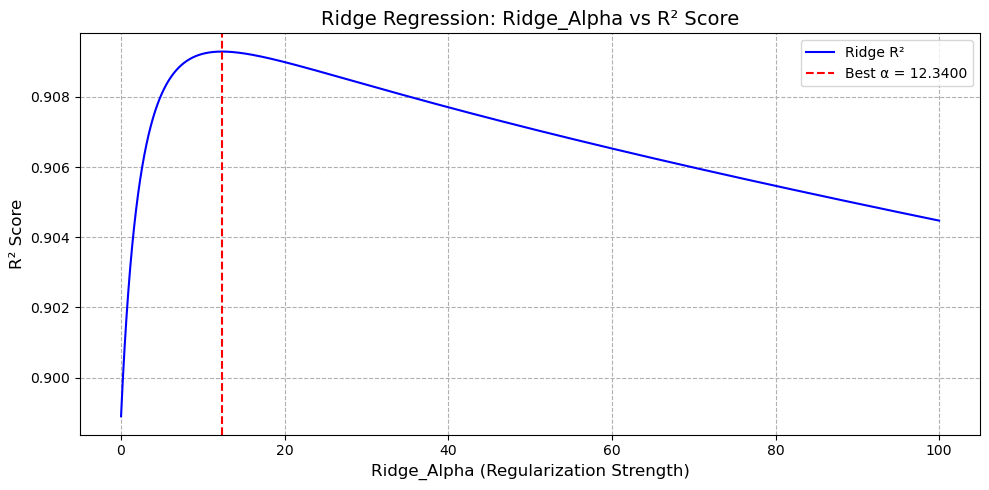

In [19]:
# 1. Ridge Regression (Analytical solution with L2 regularization) ===
# Ridge regression: solves w = argmin( ||y - Xw||² + alpha * ||w||² )
ridge_alphas = np.arange(0.01, 100, 0.01)  # Wider range, coarser step for efficiency
best_ridge_alpha = None
best_ridge_score = -np.inf
ridge_results = []

print("Tuning Ridge alpha...")

for ridge_alpha in ridge_alphas:
    # Initialize and train model
    model_ridge_sklearn = Ridge(alpha=ridge_alpha, random_state=42)  # random_state for consistency
    model_ridge_sklearn.fit(X_train_scaled, y_train)
    
    # Predict on validation set
    y_pred = model_ridge_sklearn.predict(X_val_scaled)
    
    # Evaluate using R² score
    r2 = r2_score(y_val, y_pred)
    ridge_results.append((ridge_alpha, r2))
    
    # Update best score and alpha
    if r2 > best_ridge_score:
        best_ridge_score = r2
        best_ridge_alpha = ridge_alpha

        best_model_ridge_sklearn = Ridge(alpha=best_ridge_alpha, random_state=42)
        best_model_ridge_sklearn.fit(X_train_scaled, y_train)


# Final best result
print(f"Best Ridge alpha: {best_ridge_alpha:.4f}")
print(f"Best Ridge R² score: {best_ridge_score:.4f}")

# Convert results to DataFrame
df_ridge = pd.DataFrame(ridge_results, columns=['Ridge_Alpha', 'R2'])

# Display top 5 alphas
print("\nTop 5 Ridge alpha values by R²:")
print(df_ridge.sort_values(by='R2', ascending=False).head())

# Plot: Ridge Alpha vs R² Score
plt.figure(figsize=(10, 5))
plt.plot(df_ridge['Ridge_Alpha'], df_ridge['R2'], color='blue', linewidth=1.5, label='Ridge R²')
plt.axvline(best_ridge_alpha, color='red', linestyle='--', 
            label=f'Best α = {best_ridge_alpha:.4f}')

plt.title('Ridge Regression: Ridge_Alpha vs R² Score', fontsize=14)
plt.xlabel('Ridge_Alpha (Regularization Strength)', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=1.0)
plt.tight_layout()
plt.show()

### Numerical optimization

In [20]:
# 2. Ridge Regression (Numerical optimization with L2 regularization)
# In Keras, we add L2 regularization to the Dense layer to mimic Ridge
model_ridge_keras = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(
        1,
        kernel_regularizer=tf.keras.regularizers.l2(best_ridge_alpha),  # L2 penalty on weights
        use_bias=True
    )
])

# Compile model
model_ridge_keras.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
    loss='mse',         # Mean Squared Error
    metrics=['mae']
)

# Train the model
history = model_ridge_keras.fit(
    X_train_scaled, y_train,
    epochs=10000,
    batch_size=512,
    verbose=0
)

# Predictions
y_pred_keras = model_ridge_keras.predict(X_val_scaled).flatten()

# Evaluation
print("R² (Keras Ridge - Gradient Descent):", r2_score(y_val, y_pred_keras))

# Extract learned weights and bias
# weights, bias = model_ridge_keras.layers[0].get_weights()
# print("Weights (Keras Ridge):", weights.flatten())
# print("Bias (Keras Ridge):", bias[0])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R² (Keras Ridge - Gradient Descent): 0.6414053216454207


## Lasso Regression

### Ordinary Least Squares (Analytical solution)

Tuning Lasso alpha...
Best Lasso alpha: 0.0005
Best Lasso R² score: 0.9154

Top 5 Lasso alpha values by R²:
    Lasso_Alpha        R2
4        0.0005  0.915366
5        0.0006  0.915356
6        0.0007  0.914733
29       0.0030  0.914513
28       0.0029  0.914503


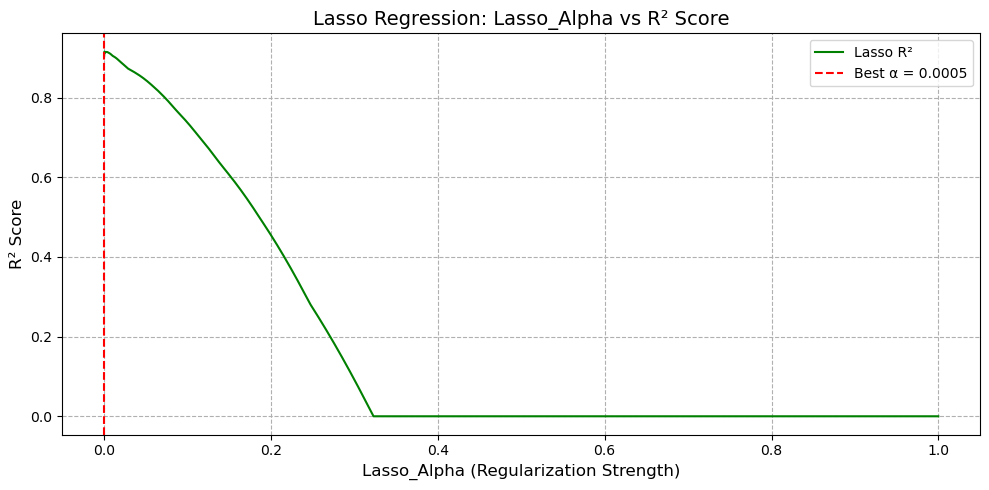

In [21]:
# === 1. Lasso Regression - Scikit-learn (Analytical solution with L1 regularization) ===
# Lasso: solves w = argmin( ||y - Xw||² + alpha * ||w||₁ )
lasso_alphas = np.arange(0.0001, 1.0, 0.0001)  # From small to moderate regularization
best_lasso_alpha = None
best_lasso_score = -np.inf
lasso_results = []

print("Tuning Lasso alpha...")

for lasso_alpha in lasso_alphas:
    # Initialize and train Lasso model
    model_lasso_sklearn = Lasso(alpha=lasso_alpha, max_iter=10000, random_state=42)
    model_lasso_sklearn.fit(X_train_scaled, y_train)
    
    # Predict on validation set
    y_pred = model_lasso_sklearn.predict(X_val_scaled)
    
    # Evaluate using R² score
    r2 = r2_score(y_val, y_pred)
    lasso_results.append((lasso_alpha, r2))
    
    # Update best score and alpha
    if r2 > best_lasso_score:
        best_lasso_score = r2
        best_lasso_alpha = lasso_alpha

        best_model_lasso_sklearn = Lasso(alpha=lasso_alpha, max_iter=10000, random_state=42)
        best_model_lasso_sklearn.fit(X_train_scaled, y_train)

# Final best result
print(f"Best Lasso alpha: {best_lasso_alpha:.4f}")
print(f"Best Lasso R² score: {best_lasso_score:.4f}")

# Convert results to DataFrame
df_lasso = pd.DataFrame(lasso_results, columns=['Lasso_Alpha', 'R2'])

# Display top 5 alphas
print("\nTop 5 Lasso alpha values by R²:")
print(df_lasso.sort_values(by='R2', ascending=False).head())

# Plot: Lasso Alpha vs R² Score
plt.figure(figsize=(10, 5))
plt.plot(df_lasso['Lasso_Alpha'], df_lasso['R2'], color='green', linewidth=1.5, label='Lasso R²')
plt.axvline(best_lasso_alpha, color='red', linestyle='--', 
            label=f'Best α = {best_lasso_alpha:.4f}')

plt.title('Lasso Regression: Lasso_Alpha vs R² Score', fontsize=14)
plt.xlabel('Lasso_Alpha (Regularization Strength)', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=1.0)
plt.tight_layout()
plt.show()

### Numerical optimization

In [22]:
# === 2. Lasso Regression - Keras (Numerical optimization with L1 regularization) ===
# In Keras, use l1 regularizer to mimic Lasso

# Ensure alpha is float32
best_lasso_alpha = np.float32(best_lasso_alpha)

# Build model
model_lasso_keras = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(
        1,
        kernel_regularizer=tf.keras.regularizers.l1(float(best_lasso_alpha)),  # ensure float32
        use_bias=True
    )
])

# Compile model
model_lasso_keras.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Convert all datasets to float32
X_train_scaled = X_train_scaled.astype(np.float32)
X_val_scaled   = X_val_scaled.astype(np.float32)
y_train        = y_train.astype(np.float32)
y_val          = y_val.astype(np.float32)

# Train model
history = model_lasso_keras.fit(
    X_train_scaled, y_train,
    epochs=10000,
    batch_size=512,
    verbose=0,
    validation_data=(X_val_scaled, y_val)
)

# Predictions
y_pred_keras = model_lasso_keras.predict(X_val_scaled).flatten()
print("R² (Keras Lasso - Gradient Descent):", r2_score(y_val, y_pred_keras))


# Extract learned weights and bias
# weights, bias = model_lasso_keras.layers[0].get_weights()
# print("Weights (Keras Lasso):", weights.flatten())
# print("Bias (Keras Lasso):", bias[0])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R² (Keras Lasso - Gradient Descent): 0.9081117510795593


# Elastic Net

### Ordinary Least Squares (Analytical solution)

Tuning ElasticNet alpha...
Best ElasticNet alpha: 0.0011
Best ElasticNet R² score: 0.9153

Top 5 ElasticNet alpha values by R²:
    Elastic_Alpha        R2
10         0.0011  0.915304
9          0.0010  0.915218
11         0.0012  0.915036
12         0.0013  0.914744
8          0.0009  0.914712


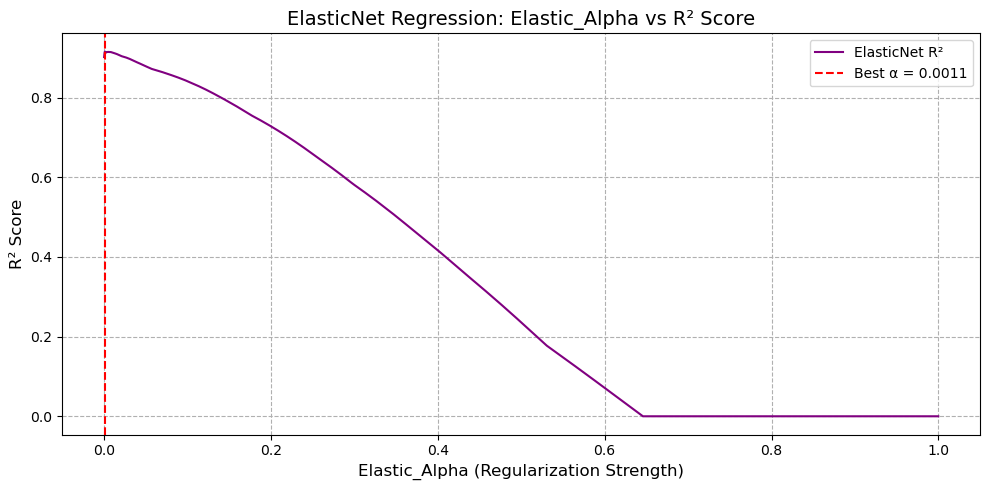

In [23]:
# === 1. Elastic Net - Scikit-learn (L1 + L2 regularization) ===
# ElasticNet: argmin( ||y - Xw||² + alpha * (l1_ratio * ||w||₁ + (1-l1_ratio) * ||w||²) )
elastic_alphas = np.arange(0.0001, 1.0, 0.0001)  # Range of regularization strengths
elastic_l1_ratio = 0.5  # Balance between L1 and L2 (0.5 = equal contribution)
best_elastic_alpha = None
best_elastic_score = -np.inf
elastic_results = []

print("Tuning ElasticNet alpha...")

for elastic_alpha in elastic_alphas:
    # Initialize and train ElasticNet model
    model_elastic_sklearn = ElasticNet(
        alpha=elastic_alpha,           # Total regularization strength
        l1_ratio=elastic_l1_ratio,     # Mix ratio: 0.5 → balanced L1/L2
        max_iter=10000,                # High iteration for convergence
        random_state=42                # For reproducibility
    )
    model_elastic_sklearn.fit(X_train_scaled, y_train)
    
    # Predict on validation set
    y_pred = model_elastic_sklearn.predict(X_val_scaled)
    
    # Evaluate using R² score
    r2 = r2_score(y_val, y_pred)
    elastic_results.append((elastic_alpha, r2))
    
    # Update best score and alpha
    if r2 > best_elastic_score:
        best_elastic_score = r2
        best_elastic_alpha = elastic_alpha
        
        best_model_elastic_sklearn = ElasticNet(
            alpha=elastic_alpha,           # Total regularization strength
            l1_ratio=elastic_l1_ratio,     # Mix ratio: 0.5 → balanced L1/L2
            max_iter=10000,                # High iteration for convergence
            random_state=42                # For reproducibility
        )
        best_model_elastic_sklearn.fit(X_train_scaled, y_train)

# Final best result
print(f"Best ElasticNet alpha: {best_elastic_alpha:.4f}")
print(f"Best ElasticNet R² score: {best_elastic_score:.4f}")

# Convert results to DataFrame
df_elastic = pd.DataFrame(elastic_results, columns=['Elastic_Alpha', 'R2'])

# Display top 5 alphas
print("\nTop 5 ElasticNet alpha values by R²:")
print(df_elastic.sort_values(by='R2', ascending=False).head())

# Plot: Elastic_Alpha vs R² Score
plt.figure(figsize=(10, 5))
plt.plot(df_elastic['Elastic_Alpha'], df_elastic['R2'], color='purple', linewidth=1.5, label='ElasticNet R²')
plt.axvline(best_elastic_alpha, color='red', linestyle='--', 
            label=f'Best α = {best_elastic_alpha:.4f}')

plt.title('ElasticNet Regression: Elastic_Alpha vs R² Score', fontsize=14)
plt.xlabel('Elastic_Alpha (Regularization Strength)', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=1.0)
plt.tight_layout()
plt.show()

### Numerical optimization

In [24]:
# === 2. Elastic Net - Keras (Numerical optimization with L1+L2 regularization) ===
# In Keras, use l1_l2() to combine L1 and L2 penalties
l1_lambda = best_elastic_alpha * elastic_l1_ratio              # L1 strength
l2_lambda = best_elastic_alpha * (1 - elastic_l1_ratio)        # L2 strength

model_elastic_keras = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(
        1,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda),
        use_bias=True
    )
])

# Compile model
model_elastic_keras.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Train the model
history = model_elastic_keras.fit(
    X_train_scaled, y_train,
    epochs=10000,
    batch_size=512,
    verbose=0,
    validation_data=(X_val_scaled, y_val)
)

# Predictions
y_pred_keras = model_elastic_keras.predict(X_val_scaled).flatten()
print("R² (Keras ElasticNet - Gradient Descent):", r2_score(y_val, y_pred_keras))

# Extract learned weights and bias
# weights, bias = model_elastic_keras.layers[0].get_weights()
# print("Weights (Keras ElasticNet):", weights.flatten())
# print("Bias (Keras ElasticNet):", bias[0])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R² (Keras ElasticNet - Gradient Descent): 0.9118122458457947


# Test data

In [25]:
# Load train dataset again 
train_raw = pd.read_csv(DATA_DIR / 'train.csv')

train_raw['MasVnrType'] = train_raw['MasVnrType'].fillna('NA')
train_raw['MasVnrArea'] = train_raw['MasVnrArea'].fillna(0)

# Load test dataset
test_data = pd.read_csv(DATA_DIR / 'test.csv')
test_raw = test_data.copy()
test_data.head()

# 1. Drop columns with too many missing values
cols_to_drop = ['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']
test_data = test_data.drop(columns=cols_to_drop)

# 2. Handle missing values

# 2.1 MasVnrType: Fill NaN with 'NA'
test_data['MasVnrType'] = test_data['MasVnrType'].fillna('NA')

# 2.2 FireplaceQu: Fill NaN with 'NA'
test_data['FireplaceQu'] = test_data['FireplaceQu'].fillna('NA')

# 2.3 Garage columns: Fill NaN with 'NA'
garage_cols = ['GarageType', 'GarageCond', 'GarageQual', 'GarageFinish']
for col in garage_cols:
    test_data[col] = test_data[col].fillna('NA')

# 2.4 Basement columns: Fill NaN with 'NA'
basement_cols = ['BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond']
for col in basement_cols:
    test_data[col] = test_data[col].fillna('NA')

# 2.5 Electrical: Fill NaN with most common value (from train)
test_data['Electrical'] = test_data['Electrical'].fillna(most_common_electrical)

# 2.6 LotFrontage: Fill NaN with mean (from train)
lotfrontage_mean = train_data['LotFrontage'].mean()
test_data['LotFrontage'] = test_data['LotFrontage'].fillna(lotfrontage_mean)

# 2.7 GarageYrBlt: Houses without garage → 0
test_data['GarageYrBlt'] = test_data['GarageYrBlt'].fillna(0)

# 2.8 MasVnrArea:
# Set MasVnrArea = 0 where MasVnrType is 'NA'
test_data.loc[(test_data['MasVnrType'] == 'NA') &
              (test_data['MasVnrArea'].notnull()), 'MasVnrArea'] = 0

# Fill NaNs: if MasVnrType = NA, area = 0 else group mean (from train)
test_data.loc[(test_data['MasVnrType'] == 'NA') &
              (test_data['MasVnrArea'].isnull()), 'MasVnrArea'] = 0

# Calculate group means based on train
group_means = train_raw.groupby('MasVnrType')['MasVnrArea'].mean()
test_data['MasVnrArea'] = test_data.apply(
    lambda row: group_means.get(row['MasVnrType'], train_raw['MasVnrArea'].mean()) 
    if pd.isna(row['MasVnrArea']) else row['MasVnrArea'],
    axis=1
)

# Fill any remaining NaN with overall mean from train
if test_data['MasVnrArea'].isnull().any():
    test_data['MasVnrArea'] = test_data['MasVnrArea'].fillna(train_data['MasVnrArea'].mean())

basement_categorical = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in basement_categorical:
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna('NA')

# If any basement feature is missing and categorical says no basement → 0
basement_numeric = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
for col in basement_numeric:
    test_data[col] = test_data[col].fillna(0)

# If no basement, set to 0
test_data['BsmtFullBath'] = test_data['BsmtFullBath'].fillna(0)
test_data['BsmtHalfBath'] = test_data['BsmtHalfBath'].fillna(0)

# If no garage, set to 0
# Ensure GarageType is filled (already done)
if 'GarageType' in test_data.columns:
    # You can optionally use GarageType to decide, but simpler: just fill NaN with 0
    test_data['GarageCars'] = test_data['GarageCars'].fillna(0)
    test_data['GarageArea'] = test_data['GarageArea'].fillna(0)

# This is categorical, but missing → fill with mode from TRAIN
if 'KitchenQual' in test_data.columns:
    kitchen_mode = train_raw['KitchenQual'].mode()[0]  
    test_data['KitchenQual'] = test_data['KitchenQual'].fillna(kitchen_mode)

# 3. Convert MSSubClass to categorical
test_data['MSSubClass'] = test_data['MSSubClass'].astype('object')

# 4. Log transform skewed features (only numeric features)
cols_to_log = ['LotArea', '1stFlrSF', 'GrLivArea', 'TotalBsmtSF']
for col in cols_to_log:
    test_data[col] = np.log1p(test_data[col])

# 5. One-hot encode nominal features
test_data = pd.get_dummies(
    test_data,
    columns=nominal_features,
    drop_first=True
)

# 6. Apply ordinal mapping
for key, value in ordinal_mapping.items():
    if key in test_data.columns:
        test_data[key] = test_data[key].fillna('NA')
        test_data[key] = test_data[key].map(value)

# 7. Align test features with training columns
test_data = test_data.reindex(columns=X_train.columns, fill_value=0)

test_data


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,80.0,9.360741,5,6,1961,1961,0.0,3,3,...,False,False,False,False,True,False,False,False,True,False
1,20,81.0,9.565775,6,6,1958,1958,108.0,3,3,...,False,False,False,False,True,False,False,False,True,False
2,60,74.0,9.534668,5,5,1997,1998,0.0,3,3,...,False,False,False,False,True,False,False,False,True,False
3,60,78.0,9.208238,6,6,1998,1998,20.0,3,3,...,False,False,False,False,True,False,False,False,True,False
4,120,43.0,8.518392,8,5,1992,1992,0.0,4,3,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,7.568896,4,7,1970,1970,0.0,3,3,...,False,False,False,False,True,False,False,False,True,False
1455,160,21.0,7.546974,4,5,1970,1970,0.0,3,3,...,False,False,False,False,True,False,False,False,False,False
1456,20,160.0,9.903538,5,7,1960,1996,0.0,3,3,...,False,False,False,False,True,False,False,False,False,False
1457,85,62.0,9.253591,5,5,1992,1992,0.0,3,3,...,False,False,False,False,True,False,False,False,True,False


In [26]:
# Scale test data by transform
test_scaled = scaler.transform(test_data)
test_scaled

array([[-0.85740877,  0.48155112,  0.474646  , ..., -0.12521758,
         0.45226702, -0.29611918],
       [-0.85740877,  0.52890471,  0.87528806, ..., -0.12521758,
         0.45226702, -0.29611918],
       [ 0.07878566,  0.19742953,  0.81450429, ..., -0.12521758,
         0.45226702, -0.29611918],
       ...,
       [-0.85740877,  4.26983892,  1.53528824, ..., -0.12521758,
        -2.21108319, -0.29611918],
       [ 0.66390717, -0.37081364,  0.26527179, ..., -0.12521758,
         0.45226702, -0.29611918],
       [ 0.07878566,  0.19742953,  0.10668124, ..., -0.12521758,
         0.45226702, -0.29611918]])

In [27]:
# Dictionary 
models = {
    "linear_keras": model_linear_keras,
    "linear_sklearn": model_linear_sklearn,
    "ridge_keras": model_ridge_keras,
    "ridge_sklearn": best_model_ridge_sklearn,
    "lasso_keras": model_lasso_keras,
    "lasso_sklearn": best_model_lasso_sklearn,
    "elastic_keras": model_elastic_keras,
    "elastic_sklearn": best_model_elastic_sklearn,
}

model_dir = ROOT_PATH / 'models'
model_dir.mkdir(exist_ok=True)

for name, model in models.items():
    # Predict
    y_pred = model.predict(test_scaled)
    if hasattr(y_pred, "flatten"):
        y_pred = np.expm1(y_pred).flatten()

    submission = pd.DataFrame({
        'Id': test_raw['Id'],
        'SalePrice': y_pred
    })

    submission.to_csv(model_dir / f'submission_{name}.csv', index=False)
    print(f"Submission file saved as submission_{name}.csv")

    # Save models with correct extension
    if 'keras' in name:  
        model.save(model_dir / f'{name}.keras')    # Native Keras format
    else:
        joblib.dump(model, model_dir / f'{name}.pkl')  # Scikit-learn


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
Submission file saved as submission_linear_keras.csv
Submission file saved as submission_linear_sklearn.csv
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
Submission file saved as submission_ridge_keras.csv
Submission file saved as submission_ridge_sklearn.csv
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
Submission file saved as submission_lasso_keras.csv
Submission file saved as submission_lasso_sklearn.csv
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
Submission file saved as submission_elastic_keras.csv
Submission file saved as submission_elastic_sklearn.csv


# Evaluate model

In [28]:
def evaluate_model(name, model, X_val, y_val):
    y_pred = model.predict(X_val)
    if hasattr(y_pred, "flatten"):
        y_pred = y_pred.flatten()
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return {"Model": name, "MSE": mse, "MAE": mae, "R2": r2}

results = []

# Loop over 
for name, model in models.items():
    # Evaluate
    metrics = evaluate_model(name, model, X_val_scaled, y_val)
    results.append(metrics)

# Summary
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="R2", ascending=False)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


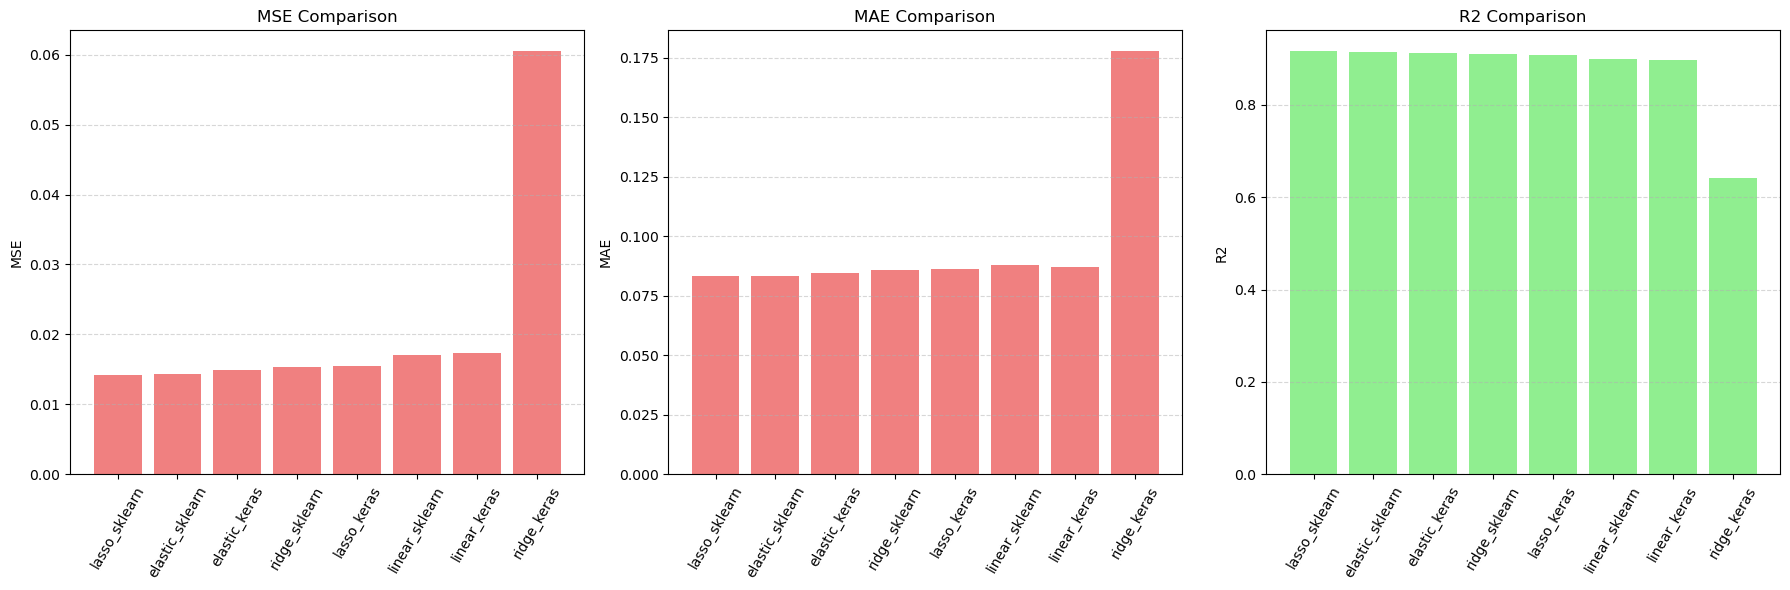

In [29]:
# Multiple metrics subplot
metrics = ['MSE', 'MAE', 'R2']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

for ax, metric in zip(axes, metrics):
    ax.bar(df_results['Model'], df_results[metric], color='lightcoral' if metric != 'R2' else 'lightgreen')
    ax.set_title(f"{metric} Comparison")
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=60)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()